#Домашнее задание № 5. Сингулярный спектральный анализ.

##Загрузим необходимые данные

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# загрузим данные
!wget 'https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._Лекция_tsml.zip'

--2025-02-26 15:27:33--  https://u.netology.ru/backend/uploads/lms/attachments/files/data/47497/1._%D0%9B%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_tsml.zip
Resolving u.netology.ru (u.netology.ru)... 213.180.193.247, 2a02:6b8::1da
Connecting to u.netology.ru (u.netology.ru)|213.180.193.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 769056 (751K) [application/x-zip-compressed]
Saving to: ‘1._Лекция_tsml.zip’

1._Лекция_tsml.zip  100%[===================>] 751.03K  1.03MB/s    in 0.7s    

2025-02-26 15:27:35 (1.03 MB/s) - ‘1._Лекция_tsml.zip’ saved [769056/769056]



In [5]:
# распакуем
import zipfile

with zipfile.ZipFile('/content/1._Лекция_tsml.zip', 'r') as zip_ref:
    zip_ref.extractall('unpacked_files')

В качестве ряда для анализа выберу monthly_boston_armed_robberies_j. Он мне кажется самым интересным.

In [6]:
# 2. ежемесячные_бостонские вооруженные_ ограбления_j
monthly_boston_armed_robberies_j = pd.read_csv('/content/unpacked_files/Series/monthly-boston-armed-robberies-j.csv')

In [7]:
series = monthly_boston_armed_robberies_j['Count']

In [8]:
# вывод графиков
def chart_2(series_1, series_2=None, title=None):
    plt.figure(figsize=(14, 7))
    plt.plot(series_1, label='Временной ряд')
    if series_2 is not None:
        plt.plot(series_2, label=title)
    plt.title('Визуальное сравнение полученного временного ряда')
    plt.xlabel('Время')
    plt.ylabel('Величина')
    plt.grid(False)
    plt.legend()
    plt.show()

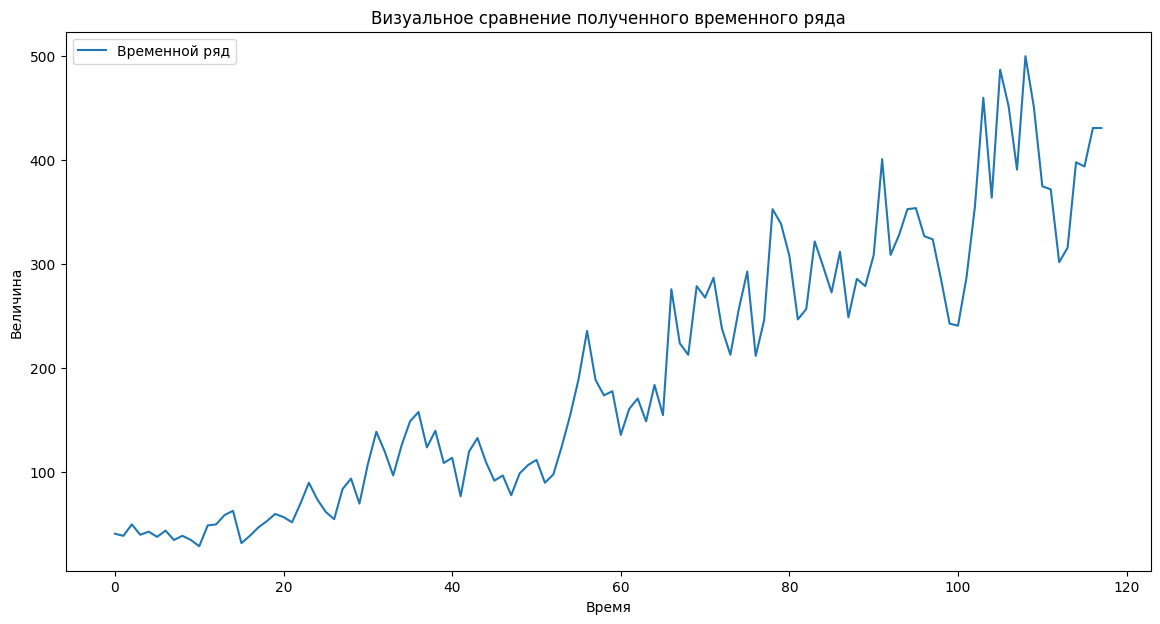

In [9]:
# посмотрим на график
chart_2(series)

###SSA

Разложение

In [10]:
import scipy.linalg
import seaborn as sns

In [11]:
# получим матрицу Ханкеля
def embed(TS, window_length):
    # вставим временной ряд в матрицу Ханкеля
    K = len(TS) - window_length + 1
    trajectory_matrix = scipy.linalg.hankel(TS, np.zeros(window_length)).T[:, : K]
    return trajectory_matrix

In [12]:
# посмотрим на размер ряда
len(series)

118

In [34]:
# зададим размер окна
# принимаю, что он совпадает с предполагаемой сезонностью
window_length = 12

In [35]:
# получим матрицу
t_matrix = embed(series, window_length)
t_matrix[1]

array([ 39.,  50.,  40.,  43.,  38.,  44.,  35.,  39.,  35.,  29.,  49.,
        50.,  59.,  63.,  32.,  39.,  47.,  53.,  60.,  57.,  52.,  70.,
        90.,  74.,  62.,  55.,  84.,  94.,  70., 108., 139., 120.,  97.,
       126., 149., 158., 124., 140., 109., 114.,  77., 120., 133., 110.,
        92.,  97.,  78.,  99., 107., 112.,  90.,  98., 125., 155., 190.,
       236., 189., 174., 178., 136., 161., 171., 149., 184., 155., 276.,
       224., 213., 279., 268., 287., 238., 213., 257., 293., 212., 246.,
       353., 339., 308., 247., 257., 322., 298., 273., 312., 249., 286.,
       279., 309., 401., 309., 328., 353., 354., 327., 324., 285., 243.,
       241., 287., 355., 460., 364., 487., 452., 391.])

In [36]:
# проверим
series[:(len(series)-window_length+2)]

,Count
0,41
1,39
2,50
3,40
4,43
...,...
103,460
104,364
105,487
106,452


In [37]:
# разложим матрицу траекторий на ее сингулярные значения и векторы
def decompose(trajectory_matrix):
    S = np.matmul(trajectory_matrix, trajectory_matrix.T)
    singular_vectors, singular_values, _ = scipy.linalg.svd(S)
    singular_values = np.sqrt(singular_values)
    rank = np.linalg.matrix_rank(trajectory_matrix)

    return rank, singular_values, singular_vectors

In [38]:
# посмотрим
rank, s_values, s_vectors = decompose(t_matrix)
print(f'rank={rank}\nsingular_values=\n{s_values}\nsingular_vectors=\n{s_vectors[0]}')

rank=12
singular_values=
[8075.39072538  792.6616212   641.43156368  381.60688729  375.87381014
  354.7650473   353.50944261  329.81454337  304.3926409   243.030621
  223.26662852  184.55961212]
singular_vectors=
[-0.2636809  -0.24591618  0.38867598  0.30443    -0.3838162   0.03457128
 -0.0777935   0.33576797 -0.20980979 -0.48665889 -0.21913502 -0.17341217]


Реконструкция

In [39]:
# сгруппируем сингулярные значения и векторы в матрицы
def group(trajectory_matrix, rank, singular_values, singular_vectors):

    V = {i: np.matmul(trajectory_matrix.T, singular_vectors[:,i]) / singular_values[i] for i in range(rank)}
    # ранг каждой матрицы равен 1
    X = {
        i: np.matmul(singular_values[i]*singular_vectors[:,i].reshape(-1,1), V[i].reshape(-1,1).T)
        for i in range(rank)
    }
    return X

In [40]:
X = group(t_matrix, rank, s_values, s_vectors)
X[0]

array([[ 36.5866976 ,  37.32405682,  38.92359195, ..., 364.02093404,
        368.93349459, 365.32571277],
       [ 37.22453199,  37.97474596,  39.60216659, ..., 370.36709489,
        375.36529858, 371.69462048],
       [ 38.18831554,  38.95795337,  40.62750969, ..., 379.95630117,
        385.08391378, 381.31819784],
       ...,
       [ 41.7737459 ,  42.61564361,  44.44195148, ..., 415.62969599,
        421.23873068, 417.11945862],
       [ 42.36625585,  43.22009485,  45.07230669, ..., 421.5248994 ,
        427.21349144, 423.03579251],
       [ 42.94746713,  43.81301972,  45.69064156, ..., 427.30768623,
        433.07431854, 428.83930687]])

In [41]:
# принимем сгруппированные матрицы в качестве входных данных
# и возвратим реконструированный временной ряд
def diagonal_averaging(X, m):
    # антидиагональное усреднение заданной матрицы Ханкеля
    if m > len(X):
        raise ValueError('Number of singular values cannot be greater than the rank of the trajectory matrix.')

    result = []
    matrix = np.sum([X[i] for i in range(m)], axis=(0))
    rows, columns = matrix.shape
    rows_star, columns_star = min(rows, columns), max(rows, columns)

    for k in range(1-columns_star, rows_star):
        identity_matrix = np.eye(columns_star, k=k, dtype='bool')[::-1][:rows_star,:]
        identity_matrix_sum = np.sum(identity_matrix)
        mask = np.ma.masked_array(matrix, mask=1-identity_matrix)
        average = mask.sum() / identity_matrix_sum
        result.append(average)

    return pd.DataFrame(result).rename(columns={0: 'reconstruction'})

In [42]:
# выбираем первую матрицу сгруппированного разложения и выполняем диагональное усреднение
# в результате получаем восстановленный временной ряд
reconstructed_time_series = diagonal_averaging(X, 1)
reconstructed_time_series[:5]

,reconstruction
0,36.586698
1,37.274294
2,38.362218
3,39.408562
4,40.020518


In [43]:
# результат из первых 2-х матриц
reconstructed_time_series = diagonal_averaging(X, 2)

In [44]:
# сравним
reconstructed_time_series['original'] = pd.DataFrame(series)['Count']
reconstructed_time_series

,reconstruction,original
0,40.130139,41
1,40.837138,39
2,41.255342,50
3,40.909541,40
4,40.129697,43
...,...,...
113,364.882055,316
114,364.331262,398
115,369.810840,394
116,382.737396,431
